In [1]:
import torch
import matplotlib.pyplot as plt
import copy
from score_models import VE, VP
from dataclasses import dataclass
from torch import distributions

import numpy as np
import torch.nn as nn
from scipy.stats import norm

from torch import Tensor
from scipy.spatial import Voronoi, voronoi_plot_2d

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'font.size': 18,
})

# Set parameters
device = torch.device('cpu')

# set seed
torch.manual_seed(0)
np.random.seed(1)

## Define Data

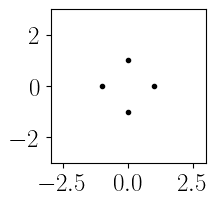

In [43]:
#N    = 20
dim  = 2
#t    = np.linspace(0,2*np.pi,3)[:,np.newaxis]
#data = np.hstack((np.cos(t), np.sin(t)))
#print(data.shape)
data = np.array([[-1,0],[1,0],[0,-1],[0,1]])

# plot data points
plt.figure(figsize=(2,2))
plt.plot(data[:,0],data[:,1],'.k')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

## Define models

In [44]:
from scipy import integrate
from scipy.special import softmax 

class MeanFieldODE(nn.Module):
    def __init__(self, train_data):
        super().__init__()
        self.train_data = train_data
        self.beta = 1.0

    def marginal_std(self, t):
        return np.exp(-1.0*t)

    def pdf_weights(self, x, t):
        # compute sigma
        sigma = self.marginal_std(t)
        # evaluate Gaussian densities
        logpdf_x_yi = np.zeros((x.shape[0],self.train_data.shape[0]))
        for i in range(self.train_data.shape[0]):
            logpdf_x_yi[:,i] = self.log_normal_pdf(x, self.train_data[i,:], sigma)
        # compute weighted average
        return softmax(logpdf_x_yi, axis=1)
        
    def log_normal_pdf(self, x, y, sigma):
        # ignoring normalization constant
        assert(x.shape[0] == len(sigma))
        return -0.5*np.sum((x - y)**2,axis=1)/sigma**2

    def normalized_weights(self, x, t):
        # compute weights
        weights = self.pdf_weights(x, t)     
        # compute weighted average
        evals = np.matmul(weights, self.train_data) 
        # check NaNs for zero weights
        evals[np.isnan(evals)] = 0.0
        return evals

    def ODEsampler(self, latents, T0=0.0, T1=1.0, err_tol=1e-5):

        # The ODE function for use by the ODE solver
        def ode_func(t, x):
            batch_time   = np.ones((latents.shape[0],)) * t
            batch_sample = x.reshape(latents.shape)
            rhs = - (batch_sample - self.normalized_weights(batch_sample, batch_time))
            return rhs.reshape((-1,))

        # Run the black-box ODE solver
        res = integrate.solve_ivp(ode_func, (T0, T1), latents.reshape(-1), rtol=err_tol, atol=err_tol, method='RK45')
        return res.y.reshape((latents.shape[0],latents.shape[1],len(res.t))), res.t


# define GMM
gmm = MeanFieldODE(data)

# test gaussian mixture weight evaluations
dim = data.shape[1]
rand_x = np.random.randn(1000, dim)
rand_t = np.random.rand(1000,)
print(gmm.normalized_weights(rand_x, rand_t).shape)

# generate new samples
Neval = 600
latents = np.random.randn(Neval, dim)
print(gmm.ODEsampler(latents)[0].shape)

(1000, 2)
(600, 2, 5)


## Compute model weights

In [45]:
# define latent samples
scaling = 2.1 #2.2
batch_size = 21#11#41#21#11
latent_x   = scaling*torch.linspace(-1,1,batch_size)[np.newaxis,:]
latents_1  = torch.vstack((latent_x, scaling*torch.ones(1,batch_size))).T #torch.randn(batch_size, dim).to(device)
latents_2  = torch.vstack((latent_x, -scaling*torch.ones(1,batch_size))).T #torch.randn(batch_size, dim).to(device)
latents_3  = torch.vstack((scaling*torch.ones(1,batch_size-2), latent_x[:,1:-1])).T #torch.randn(batch_size, dim).to(device)
latents_4  = torch.vstack((-scaling*torch.ones(1,batch_size-2),latent_x[:,1:-1])).T #torch.randn(batch_size, dim).to(device)
latents = torch.vstack((latents_1, latents_2, latents_3, latents_4))
batch_size = latents.shape[0]

# evaluate ODE and SDE paths
GMM_x, GMM_t = gmm.ODEsampler(latents, T1=100.0, err_tol=1e-7)
# define array to store weights
#GMMweights = torch.zeros((len(GMM_t),batch_size,gmm_train.train_data.shape[0]))

# # evaluate the ODE weights
# for (j,tj) in enumerate(GMM_t):
#     sample = torch.tensor(GMM_x[:,j], device=latents.device, dtype=torch.float32).reshape(latents.shape)
#     batch_time = torch.ones(batch_size, device=latents.device) * tj
#     GMMweights[j,:,:] = gmm_train.pdf_weights(sample, batch_time)

### Plot ODE weights

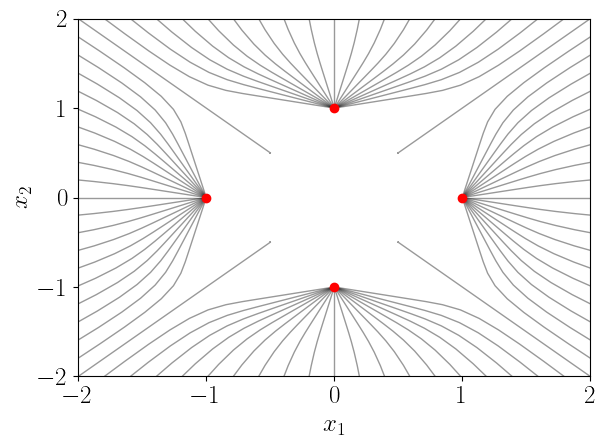

In [47]:
ctr = 1
plt.figure()
for i in range(batch_size):
    plt.plot(GMM_x[i,0,:], GMM_x[i,1,:], '-k', alpha=0.4, linewidth=1)
plt.plot(data[:,0],data[:,1],'.r',markersize=12)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.tight_layout()
plt.savefig('ODE_trajectories_fourpoints.pdf')

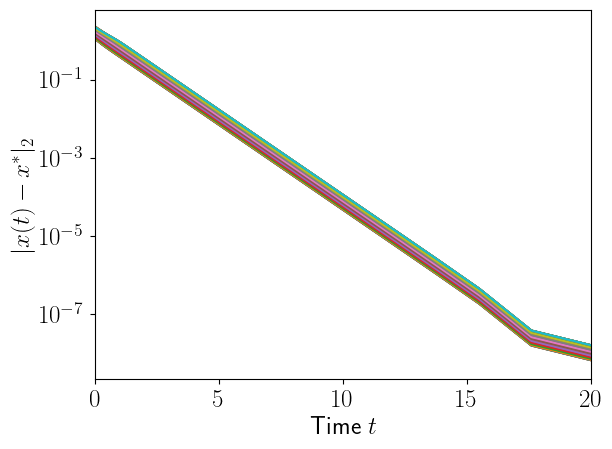

In [50]:
plt.figure()
for i in range(batch_size):
    # compute distance to final point
    res_i = GMM_x[i,:,:]
    dist = np.sqrt(np.sum((res_i - res_i[:,-1][:,np.newaxis])**2, axis=0))
    plt.semilogy(GMM_t, dist)
plt.xlabel('Time $t$')
plt.ylabel('$|x(t) - x^*|_2$')
plt.xlim(0,20)
#plt.savefig('exponential_convergence.pdf')
plt.show()